In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Adding root directory to sys.path (list of directories python look in for packages and modules)
import sys, os
from pathlib import Path


root_dir = os.path.abspath("../../../")
print("Root dir: ", Path(root_dir).stem)
sys.path.append( root_dir )

Root dir:  pytorch-stardist


In [3]:
import time
import warnings

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch


from stardist_tools import calculate_extents, Rays_GoldenSpiral
from stardist_tools.matching import matching, matching_dataset
from stardist_tools.csbdeep_utils import download_and_extract_zip_file


from src.training import train

from src.data.stardist_dataset import get_train_val_dataloaders

from utils import seed_all, prepare_conf, plot_img_label

from src.models.config import ConfigBase, Config3D

from src.models.stardist3d import StarDist3D

### Data download

In [4]:
download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.3.0/demo3D.zip',
    targetdir = 'datasets\demo',
    verbose   = 1,
)

Files found, nothing to download.


### Configuration

In [5]:
print( ConfigBase.__doc__ )


            Configuration for a StarDist model.

            Parameters
            ----------
            data_dir: str or None
                path to data directory with the following structure:
                
                data_dir
                    |train
                    |----|images
                    |----|masks
                    |val [Optional]
                    |----|images
                    |----|masks

                if the directory `val` is absent, the data in the `train` folder will be splitted.
                
                
            
            patch_size: tuple
                size of image to crop from original images.
            load_epoch: int or 'best' or None
                if not None, will load state corresponding to epoch `load_epoch`
            
            Attributes
            ----------
            name: str
                Name to give to the model
            random_seed: int
                Seed to use for reproductibility



In [7]:
conf = Config3D(
    name                           = 'demo',
    random_seed                    = 42,
    
    # ========================= dataset ==================================

    data_dir                       = r'datasets\demo',
    n_rays                         = 96,
    foreground_prob                = 0.9,
    n_classes                      = None, # non null value (multiclass) not supported yet,
    patch_size                     = [48, 96, 96],
    cache_sample_ind               = True,
    cache_data                     = True,

    batch_size                     = 2,
    num_workers                    = 0, #4,

    preprocess                     = "flip_randintensity",
    preprocess_val                 = "none",
    intensity_factor_range         = [0.6, 2.],
    intensity_bias_range           = [-0.2, 0.2],

    #======================================================================
    
    
    # ========================= Networks configurations ==================
    n_channel_in                   = 1,
    resnet_n_blocks                = 4,
    #======================================================================

    
    # ========================= Training ==================================

    use_gpu                        = True if torch.cuda.is_available() else False,
    use_amp                        = True,
    isTrain                        = True ,
    evaluate                       = True, #True,
    #gpu_ids                       = [0]
    #continue_train                = False


    load_epoch                     = None,
    n_epochs                       = 400,
    n_steps_per_epoch              = 100,

    save_epoch_freq                = 50,
    start_saving_best_after_epoch  = 5,
    
    lambda_prob                    = 1.,
    lambda_dist                    = 0.2,
    lambda_reg                     = 0.0001,
    lambda_prob_class              = 1.,

    #======================================================================


    # ========================= Optimizers ================================
    lr                             = 0.0003, #0.0002,

    lr_policy                      = "plateau",
    lr_plateau_factor              = 0.5,
    lr_plateau_threshold           = 0.0000001,
    lr_plateau_patience            = 40,
    min_lr                         = 1e-6
)

In [8]:
seed_all(conf.random_seed)

[ Using Seed :  42  ]


In [9]:
opt = prepare_conf(conf)


 === Computing extents...


stardist_dataset.py (102): didn't find the validation folder <datasets\demo\val>. Splitting data from datasets\demo\train with val_size=0.15


If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
 === Computing anisotropy...
 === Empirical anisotropy of labeled objects = (2.0, 1.0, 1.0)
 === 'grid' set to (1, 2, 2)



### Initializing/loading model

In [10]:
model = StarDist3D(opt)

initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 1.6 million. To see the architecture, do print(network).


In [11]:
model.opt.n_epochs

400

In [12]:
fov = np.array( [max(r) for r in model._compute_receptive_field()] )
object_median_size = opt.extents

print("Median object size".ljust(25), ":", object_median_size)
print("Network field of veiw".ljust(25), ":", fov)

if any(object_median_size > fov):
    warnings.warn("WARNING: median object size larger than field of view of the neural network.")

Median object size        : [10. 20. 20.]
Network field of veiw     : [17 29 29]


### Loading data

In [13]:
rays = Rays_GoldenSpiral(opt.n_rays, anisotropy=opt.anisotropy)



train_dataloader, val_dataloader = get_train_val_dataloaders(opt, rays)
    

total_nb_samples = len( train_dataloader.dataset ) + ( len(val_dataloader.dataset) if val_dataloader is not None else 0 )
nb_samples_train = len(train_dataloader.dataset)
nb_samples_val = total_nb_samples - nb_samples_train

print("Total nb samples: ".ljust(40), total_nb_samples)
print("Train nb samples: ".ljust(40), nb_samples_train)
print("Val nb samples: ".ljust(40), nb_samples_val)

Total nb samples:                        27
Train nb samples:                        23
Val nb samples:                          4


In [14]:
print("Train augmentation".ljust(25), ":",  train_dataloader.dataset.opt.preprocess)
print("Val augmentation".ljust(25), ":", val_dataloader.dataset.opt.preprocess)

Train augmentation        : flip_randintensity
Val augmentation          : none


In [15]:
X, Y = train_dataloader.dataset.get_image_mask(0)

In [16]:
#X.min(), X.max(), Y.dtype

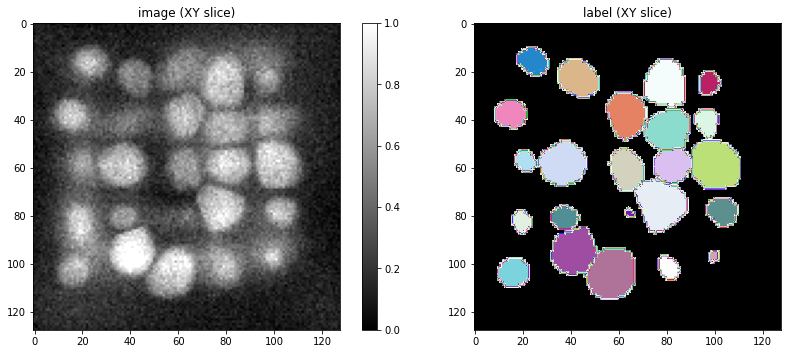

In [17]:
plot_img_label( X[0], Y )

### Data Augmentation

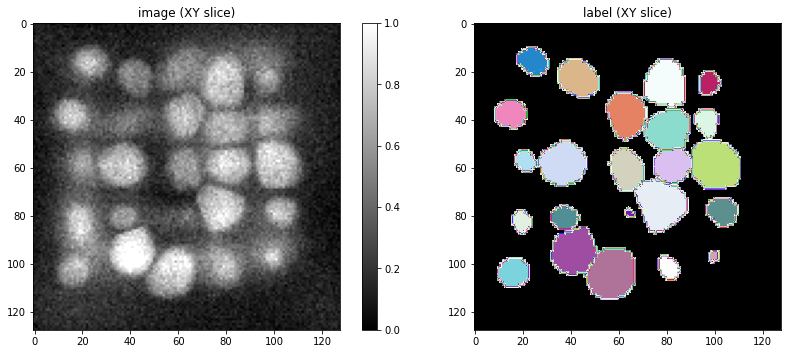

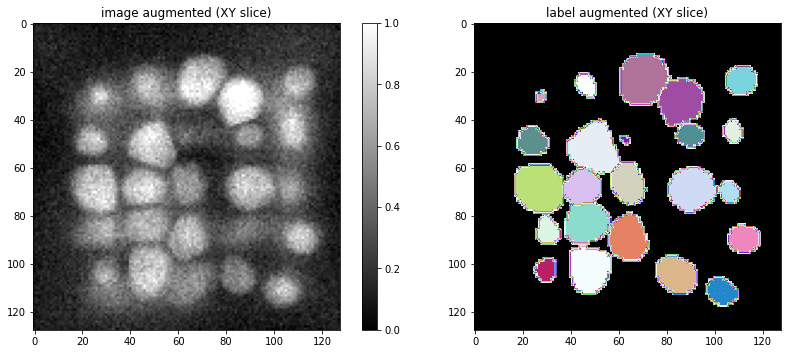

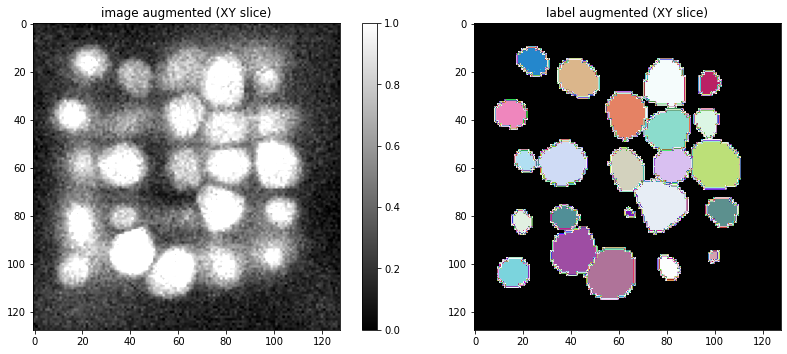

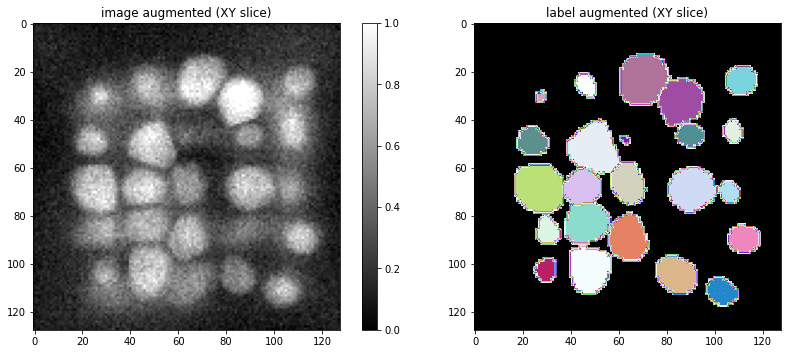

In [18]:
img, lbl = train_dataloader.dataset.get_image_mask(0, apply_transform=False)
plot_img_label(img[0], lbl)
for _ in range(3):
    img_aug, lbl_aug = train_dataloader.dataset.get_image_mask(0, apply_transform=True)
    plot_img_label(img_aug[0], lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

### Training

In [19]:
%%time
train(model, train_dataloader, val_dataloader)

[Epoch 1/400] [Steps 100/100] [Loss: 1.4205 Loss_dist: 4.5830 Loss_prob: 0.5039 Loss_prob_class: 0.0000] Duration 0:00:40.638911
[Epoch 1/400] [Batch 2/2] [Val_loss: 1.1420 Val_loss_dist: 3.6785 Val_loss_prob: 0.4063 Val_loss_prob_class: 0.0000]  Duration 0:00:01.009811
learning rate 0.0003000 -> 0.0003000
---
[Epoch 2/400] [Steps 100/100] [Loss: 0.9882 Loss_dist: 3.3886 Loss_prob: 0.3105 Loss_prob_class: 0.0000] Duration 0:00:37.803501
[Epoch 2/400] [Batch 2/2] [Val_loss: 0.9101 Val_loss_dist: 3.0149 Val_loss_prob: 0.3071 Val_loss_prob_class: 0.0000]  Duration 0:00:00.671829
learning rate 0.0003000 -> 0.0003000
---
[Epoch 3/400] [Steps 100/100] [Loss: 0.8699 Loss_dist: 3.1579 Loss_prob: 0.2383 Loss_prob_class: 0.0000] Duration 0:00:37.717824
[Epoch 3/400] [Batch 2/2] [Val_loss: 0.6756 Val_loss_dist: 2.5059 Val_loss_prob: 0.1744 Val_loss_prob_class: 0.0000]  Duration 0:00:00.670936
learning rate 0.0003000 -> 0.0003000
---
[Epoch 4/400] [Steps 100/100] [Loss: 0.6421 Loss_dist: 2.2023 Lo

[Epoch 46/400] [Steps 100/100] [Loss: 0.2952 Loss_dist: 0.7439 Loss_prob: 0.1464 Loss_prob_class: 0.0000] Duration 0:00:37.992418
[Epoch 46/400] [Batch 2/2] [Val_loss: 0.2924 Val_loss_dist: 0.7622 Val_loss_prob: 0.1400 Val_loss_prob_class: 0.0000]  Duration 0:00:00.649379
learning rate 0.0003000 -> 0.0003000
---
[Epoch 47/400] [Steps 100/100] [Loss: 0.2939 Loss_dist: 0.7420 Loss_prob: 0.1455 Loss_prob_class: 0.0000] Duration 0:00:37.540960
[Epoch 47/400] [Batch 2/2] [Val_loss: 0.2909 Val_loss_dist: 0.7776 Val_loss_prob: 0.1353 Val_loss_prob_class: 0.0000]  Duration 0:00:00.634954
learning rate 0.0003000 -> 0.0003000
---
[Epoch 48/400] [Steps 100/100] [Loss: 0.3058 Loss_dist: 0.7883 Loss_prob: 0.1481 Loss_prob_class: 0.0000] Duration 0:00:37.602673
[Epoch 48/400] [Batch 2/2] [Val_loss: 0.2977 Val_loss_dist: 0.7382 Val_loss_prob: 0.1501 Val_loss_prob_class: 0.0000]  Duration 0:00:00.658221
learning rate 0.0003000 -> 0.0003000
---
[Epoch 49/400] [Steps 100/100] [Loss: 0.2942 Loss_dist: 0.

[Epoch 93/400] [Batch 2/2] [Val_loss: 0.4160 Val_loss_dist: 1.3136 Val_loss_prob: 0.1533 Val_loss_prob_class: 0.0000]  Duration 0:00:00.678389
learning rate 0.0003000 -> 0.0003000
---
[Epoch 94/400] [Steps 100/100] [Loss: 0.4327 Loss_dist: 1.3536 Loss_prob: 0.1620 Loss_prob_class: 0.0000] Duration 0:00:37.859874
[Epoch 94/400] [Batch 2/2] [Val_loss: 0.4236 Val_loss_dist: 1.3025 Val_loss_prob: 0.1631 Val_loss_prob_class: 0.0000]  Duration 0:00:00.714954
learning rate 0.0003000 -> 0.0003000
---
[Epoch 95/400] [Steps 100/100] [Loss: 0.4160 Loss_dist: 1.2733 Loss_prob: 0.1613 Loss_prob_class: 0.0000] Duration 0:00:38.355860
[Epoch 95/400] [Batch 2/2] [Val_loss: 0.3747 Val_loss_dist: 1.1891 Val_loss_prob: 0.1369 Val_loss_prob_class: 0.0000]  Duration 0:00:00.645672
learning rate 0.0003000 -> 0.0003000
---
[Epoch 96/400] [Steps 100/100] [Loss: 0.4100 Loss_dist: 1.2541 Loss_prob: 0.1592 Loss_prob_class: 0.0000] Duration 0:00:38.174921
[Epoch 96/400] [Batch 2/2] [Val_loss: 0.3844 Val_loss_dist

[Epoch 144/400] [Steps 100/100] [Loss: 0.3777 Loss_dist: 1.0256 Loss_prob: 0.1726 Loss_prob_class: 0.0000] Duration 0:00:38.245232
[Epoch 144/400] [Batch 2/2] [Val_loss: 0.3421 Val_loss_dist: 0.9675 Val_loss_prob: 0.1486 Val_loss_prob_class: 0.0000]  Duration 0:00:00.682223
learning rate 0.0001500 -> 0.0001500
---
[Epoch 145/400] [Steps 100/100] [Loss: 0.3261 Loss_dist: 0.8658 Loss_prob: 0.1530 Loss_prob_class: 0.0000] Duration 0:00:38.222999
[Epoch 145/400] [Batch 2/2] [Val_loss: 0.2932 Val_loss_dist: 0.7890 Val_loss_prob: 0.1354 Val_loss_prob_class: 0.0000]  Duration 0:00:00.692075
learning rate 0.0001500 -> 0.0001500
---
[Epoch 146/400] [Steps 100/100] [Loss: 0.3006 Loss_dist: 0.7705 Loss_prob: 0.1465 Loss_prob_class: 0.0000] Duration 0:00:38.242178
[Epoch 146/400] [Batch 2/2] [Val_loss: 0.2795 Val_loss_dist: 0.7561 Val_loss_prob: 0.1283 Val_loss_prob_class: 0.0000]  Duration 0:00:00.679130
learning rate 0.0001500 -> 0.0001500
---
[Epoch 147/400] [Steps 100/100] [Loss: 0.3000 Loss_d

[Epoch 194/400] [Steps 100/100] [Loss: 0.2732 Loss_dist: 0.6381 Loss_prob: 0.1456 Loss_prob_class: 0.0000] Duration 0:00:38.478534
[Epoch 194/400] [Batch 2/2] [Val_loss: 0.2639 Val_loss_dist: 0.6867 Val_loss_prob: 0.1266 Val_loss_prob_class: 0.0000]  Duration 0:00:00.655572
learning rate 0.0000750 -> 0.0000750
---
[Epoch 195/400] [Steps 100/100] [Loss: 0.2712 Loss_dist: 0.6367 Loss_prob: 0.1438 Loss_prob_class: 0.0000] Duration 0:00:38.183126
[Epoch 195/400] [Batch 2/2] [Val_loss: 0.2767 Val_loss_dist: 0.6842 Val_loss_prob: 0.1398 Val_loss_prob_class: 0.0000]  Duration 0:00:00.697922
learning rate 0.0000750 -> 0.0000750
---
[Epoch 196/400] [Steps 100/100] [Loss: 0.2713 Loss_dist: 0.6340 Loss_prob: 0.1445 Loss_prob_class: 0.0000] Duration 0:00:37.916759
[Epoch 196/400] [Batch 2/2] [Val_loss: 0.2773 Val_loss_dist: 0.6631 Val_loss_prob: 0.1447 Val_loss_prob_class: 0.0000]  Duration 0:00:00.680213
learning rate 0.0000750 -> 0.0000750
---
[Epoch 197/400] [Steps 100/100] [Loss: 0.2707 Loss_d

[Epoch 242/400] [Steps 100/100] [Loss: 0.2649 Loss_dist: 0.5951 Loss_prob: 0.1459 Loss_prob_class: 0.0000] Duration 0:00:37.845952
[Epoch 242/400] [Batch 2/2] [Val_loss: 0.2641 Val_loss_dist: 0.6457 Val_loss_prob: 0.1350 Val_loss_prob_class: 0.0000]  Duration 0:00:00.674856
learning rate 0.0000750 -> 0.0000750
---
[Epoch 243/400] [Steps 100/100] [Loss: 0.2618 Loss_dist: 0.5922 Loss_prob: 0.1434 Loss_prob_class: 0.0000] Duration 0:00:38.107765
[Epoch 243/400] [Batch 2/2] [Val_loss: 0.2602 Val_loss_dist: 0.6342 Val_loss_prob: 0.1333 Val_loss_prob_class: 0.0000]  Duration 0:00:00.688819
learning rate 0.0000750 -> 0.0000750
---
[Epoch 244/400] [Steps 100/100] [Loss: 0.2734 Loss_dist: 0.6304 Loss_prob: 0.1473 Loss_prob_class: 0.0000] Duration 0:00:38.227679
[Epoch 244/400] [Batch 2/2] [Val_loss: 0.2658 Val_loss_dist: 0.6497 Val_loss_prob: 0.1359 Val_loss_prob_class: 0.0000]  Duration 0:00:00.725804
learning rate 0.0000750 -> 0.0000750
---
[Epoch 245/400] [Steps 100/100] [Loss: 0.2674 Loss_d

[Epoch 291/400] [Batch 2/2] [Val_loss: 0.2605 Val_loss_dist: 0.6252 Val_loss_prob: 0.1355 Val_loss_prob_class: 0.0000]  Duration 0:00:00.696352
learning rate 0.0000375 -> 0.0000375
---
[Epoch 292/400] [Steps 100/100] [Loss: 0.2552 Loss_dist: 0.5563 Loss_prob: 0.1439 Loss_prob_class: 0.0000] Duration 0:00:38.321851
[Epoch 292/400] [Batch 2/2] [Val_loss: 0.2518 Val_loss_dist: 0.6224 Val_loss_prob: 0.1273 Val_loss_prob_class: 0.0000]  Duration 0:00:00.653587
learning rate 0.0000375 -> 0.0000375
---
[Epoch 293/400] [Steps 100/100] [Loss: 0.2535 Loss_dist: 0.5547 Loss_prob: 0.1426 Loss_prob_class: 0.0000] Duration 0:00:38.117414
[Epoch 293/400] [Batch 2/2] [Val_loss: 0.2512 Val_loss_dist: 0.6263 Val_loss_prob: 0.1259 Val_loss_prob_class: 0.0000]  Duration 0:00:00.644981
learning rate 0.0000375 -> 0.0000375
---
[Epoch 294/400] [Steps 100/100] [Loss: 0.2540 Loss_dist: 0.5582 Loss_prob: 0.1423 Loss_prob_class: 0.0000] Duration 0:00:38.255519
[Epoch 294/400] [Batch 2/2] [Val_loss: 0.2628 Val_lo

[Epoch 342/400] [Steps 100/100] [Loss: 0.2513 Loss_dist: 0.5412 Loss_prob: 0.1431 Loss_prob_class: 0.0000] Duration 0:00:39.032115
[Epoch 342/400] [Batch 2/2] [Val_loss: 0.2792 Val_loss_dist: 0.6176 Val_loss_prob: 0.1557 Val_loss_prob_class: 0.0000]  Duration 0:00:00.656793
learning rate 0.0000375 -> 0.0000375
---
[Epoch 343/400] [Steps 100/100] [Loss: 0.2486 Loss_dist: 0.5418 Loss_prob: 0.1403 Loss_prob_class: 0.0000] Duration 0:00:38.470258
[Epoch 343/400] [Batch 2/2] [Val_loss: 0.2621 Val_loss_dist: 0.6212 Val_loss_prob: 0.1378 Val_loss_prob_class: 0.0000]  Duration 0:00:00.676028
learning rate 0.0000375 -> 0.0000375
---
[Epoch 344/400] [Steps 100/100] [Loss: 0.2512 Loss_dist: 0.5417 Loss_prob: 0.1428 Loss_prob_class: 0.0000] Duration 0:00:38.476723
[Epoch 344/400] [Batch 2/2] [Val_loss: 0.2536 Val_loss_dist: 0.6129 Val_loss_prob: 0.1310 Val_loss_prob_class: 0.0000]  Duration 0:00:00.705858
learning rate 0.0000375 -> 0.0000375
---
[Epoch 345/400] [Steps 100/100] [Loss: 0.2535 Loss_d

[Epoch 393/400] [Steps 100/100] [Loss: 0.2472 Loss_dist: 0.5269 Loss_prob: 0.1418 Loss_prob_class: 0.0000] Duration 0:00:38.416948
[Epoch 393/400] [Batch 2/2] [Val_loss: 0.2564 Val_loss_dist: 0.6232 Val_loss_prob: 0.1318 Val_loss_prob_class: 0.0000]  Duration 0:00:00.684005
learning rate 0.0000094 -> 0.0000094
---
[Epoch 394/400] [Steps 100/100] [Loss: 0.2504 Loss_dist: 0.5287 Loss_prob: 0.1447 Loss_prob_class: 0.0000] Duration 0:00:38.176119
[Epoch 394/400] [Batch 2/2] [Val_loss: 0.2527 Val_loss_dist: 0.6106 Val_loss_prob: 0.1306 Val_loss_prob_class: 0.0000]  Duration 0:00:00.632272
learning rate 0.0000094 -> 0.0000094
---
[Epoch 395/400] [Steps 100/100] [Loss: 0.2468 Loss_dist: 0.5265 Loss_prob: 0.1415 Loss_prob_class: 0.0000] Duration 0:00:38.572722
[Epoch 395/400] [Batch 2/2] [Val_loss: 0.2649 Val_loss_dist: 0.6020 Val_loss_prob: 0.1445 Val_loss_prob_class: 0.0000]  Duration 0:00:00.669257
learning rate 0.0000094 -> 0.0000094
---
[Epoch 396/400] [Steps 100/100] [Loss: 0.2482 Loss_d

### Threshold optimization

In [20]:
conf.load_epoch="best"
best_model = StarDist3D(conf)

Load path: checkpoints\demo\best.pth cuda:0
Loading threholds ...
Instanciating network
initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 1.6 million. To see the architecture, do print(network).
<All keys matched successfully>
Optimizers, schedulers and amp_scaler loaded.
Logger loaded.
Loading model from <checkpoints\demo\best.pth>.



In [21]:
print( "Best epoch:", best_model.opt.epoch_count )

Best epoch: 305


In [22]:
X, Y = val_dataloader.dataset.get_all_data()

#X, Y = X[:2], Y[:2]

len(X), len(Y)

(4, 4)

In [23]:
%%time
best_model.optimize_thresholds(X, Y)

NMS threshold = 0.5:  75%|█████████████████████████████████▊           | 15/20 [00:48<00:16,  3.21s/it, 0.729 -> 0.985]


Using optimized values: prob_thresh=0.726973, nms_thresh=0.3.
Saving to <logs\demo\thresholds.json>
Wall time: 2min 47s


{'prob': 0.726973231031345, 'nms': 0.3}

### Evaluation on validation set

In [24]:
X, Y = val_dataloader.dataset.get_all_data()
len(X), len(Y)

(4, 4)

In [25]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/it]

Wall time: 6.19 s


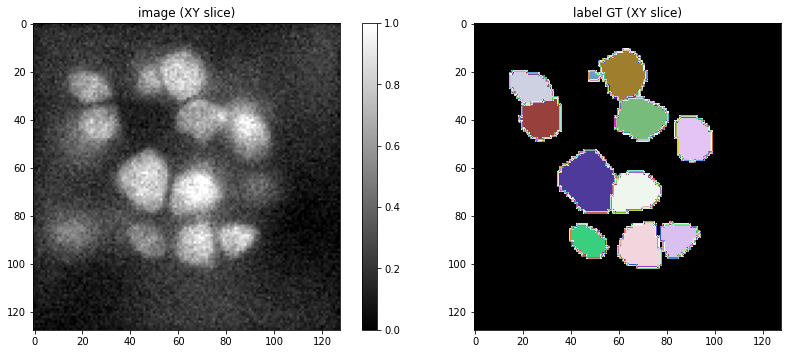

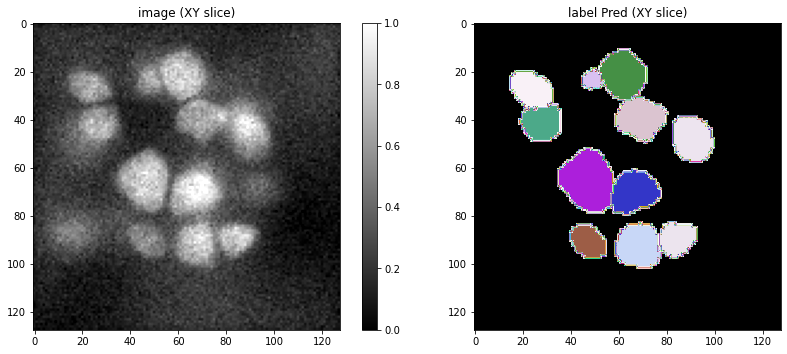

In [26]:
plot_img_label(X[0][0], Y[0], lbl_title="label GT (XY slice)")
plot_img_label(X[0][0], Y_pred[0].astype(np.float32), lbl_title="label Pred (XY slice)")

In [27]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.68s/it]


In [28]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=9, tp=375, fn=9, precision=0.9765625, recall=0.9765625, accuracy=0.9541984732824428, f1=0.9765625, n_true=384, n_pred=384, mean_true_score=0.8094205756982168, mean_matched_score=0.828846669514974, panoptic_quality=0.8094205756982168, by_image=False)

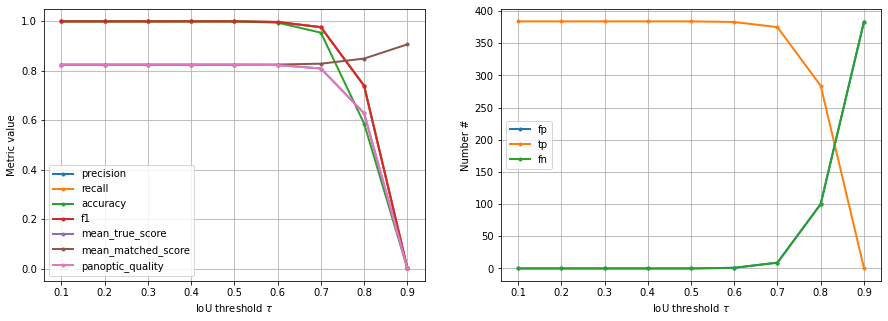

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [30]:
val_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    val_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": val_acc}).T

,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,1,1,1,1,1,0.994805,0.954198,0.586777,0.00130378


### Evaluation on Test

In [31]:
from pathlib import Path

test_dir = Path( opt.data_dir ) / "test"

test_images_dir = test_dir / "images"
test_mask_dir = test_dir / "masks"

test_image_paths = list( Path(test_images_dir).glob("*.tif") )
test_mask_paths = list( Path(test_mask_dir).glob("*.tif") )

len(test_image_paths), len( test_mask_paths )

(3, 3)

In [32]:
from stardist_tools.csbdeep_utils import normalize

In [33]:
from src.data.utils import load_img #, save_img

In [34]:
X = [ normalize( load_img(image_path).squeeze() )[np.newaxis] for image_path in test_image_paths ]
Y = [ load_img(mask_path).squeeze().astype(np.uint32) for mask_path in test_mask_paths  ]

len(X), len(Y)

(3, 3)

In [35]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.61s/it]

Wall time: 4.85 s


In [36]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.94it/s]


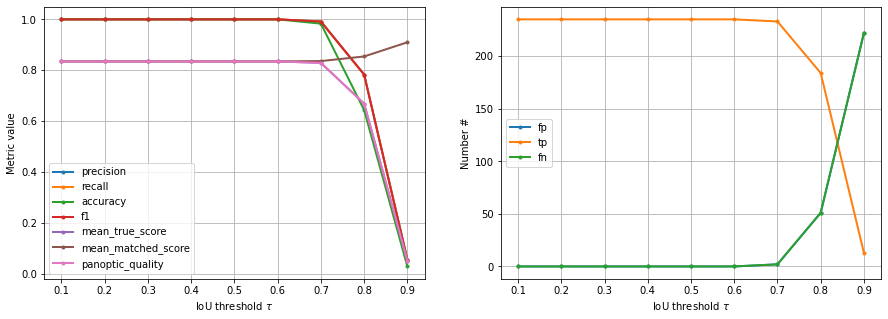

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [38]:
test_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    test_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": test_acc}).T

,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,1,1,1,1,1,1,0.983122,0.643357,0.0284464


### Evaluation on Train

In [39]:
X, Y = train_dataloader.dataset.get_all_data()
len(X), len(Y)

(23, 23)

In [40]:
conf.load_epoch="best"
best_model = StarDist3D(conf)
best_model.opt.epoch_count

Load path: checkpoints\demo\best.pth cuda:0
Loading threholds ...
Instanciating network
initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 1.6 million. To see the architecture, do print(network).
<All keys matched successfully>
Optimizers, schedulers and amp_scaler loaded.
Logger loaded.
Loading model from <checkpoints\demo\best.pth>.



305

In [41]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:40<00:00,  1.78s/it]

Wall time: 41 s


In [42]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]


In [43]:
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    print( stats[taus.index(t)].accuracy )

1.0
1.0
1.0
1.0
1.0
0.9979879275653923
0.984015984015984
0.7940379403794038
0.040607807178412364


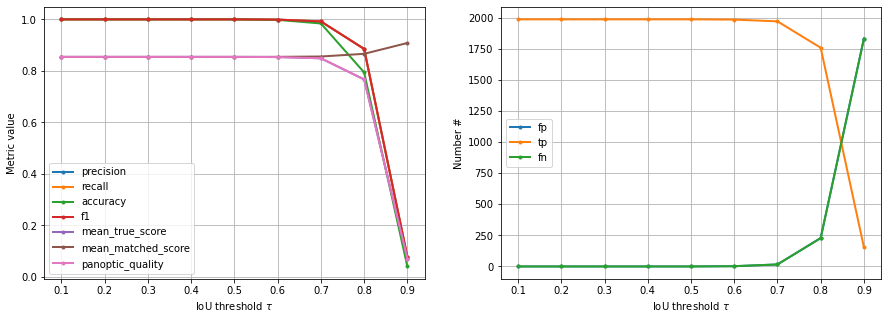

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [45]:
train_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    train_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": train_acc}).T


,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,1,1,1,1,1,0.997988,0.984016,0.794038,0.0406078
